# Regression Project

Build a linear regression model that predicts the `price` column in the dataset on San Francisco Apartment rentals.

## Data Dictionary

1. Price: The price of the rental and our target variable
2. sqft: The area in square feet of the rental
3. beds: The number of bedrooms in the rental
4. bath: The number of bathrooms in the rental
5. laundry: Does the rental have a laundry machine inside the house, a shared laundry machine, or no laundry on site?
6. pets: Does the rental allow pets? Cats only, dogs only or both cats and dogs?
7. Housing type: Is the rental in a multi-unit building, a building with two units, or a stand alone house? 
8. Parking: Does the apartment off a parking space? No, protected in a garage, off-street in a parking lot, or valet service?
9. Hood district: Which part of San Francisco is the apartment located?

![image info](./Data/SFAR_map.png)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
rentals = pd.read_csv(r"C:\Users\Akshith shetty\Desktop\Python(Projects)\Price Prediction\Data\sf_clean.csv")
rentals.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0


In [3]:
rentals.columns

Index(['price', 'sqft', 'beds', 'bath', 'laundry', 'pets', 'housing_type',
       'parking', 'hood_district'],
      dtype='object')

## Exploratory Data Analysis

In [4]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          989 non-null    int64  
 1   sqft           989 non-null    float64
 2   beds           989 non-null    float64
 3   bath           989 non-null    float64
 4   laundry        989 non-null    object 
 5   pets           989 non-null    object 
 6   housing_type   989 non-null    object 
 7   parking        989 non-null    object 
 8   hood_district  989 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 69.7+ KB


In [5]:
rentals['hood_district'] = rentals['hood_district'].astype('object')

In [6]:
rentals.describe()

,price,sqft,beds,bath
count,989.000000,989.000000,989.000000,989.000000
mean,3595.035389,976.765420,1.679474,1.390293
std,1546.222670,474.629798,1.076710,0.562714
min,750.000000,150.000000,0.000000,1.000000
25%,2650.000000,650.000000,1.000000,1.000000
50%,3300.000000,900.000000,2.000000,1.000000
75%,4242.000000,1200.000000,2.000000,2.000000
max,19000.000000,3500.000000,6.000000,4.000000


<Axes: xlabel='price', ylabel='Count'>

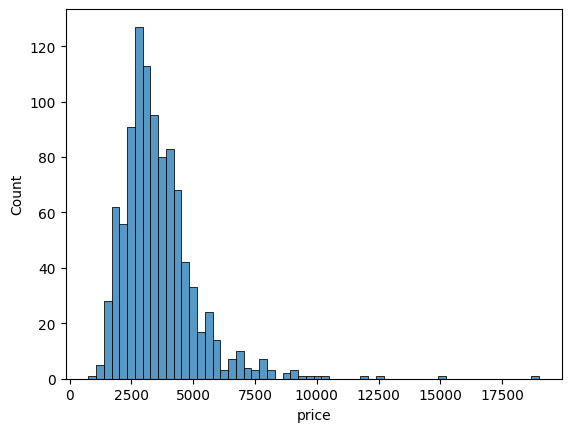

In [7]:
sns.histplot(data = rentals,x = 'price')

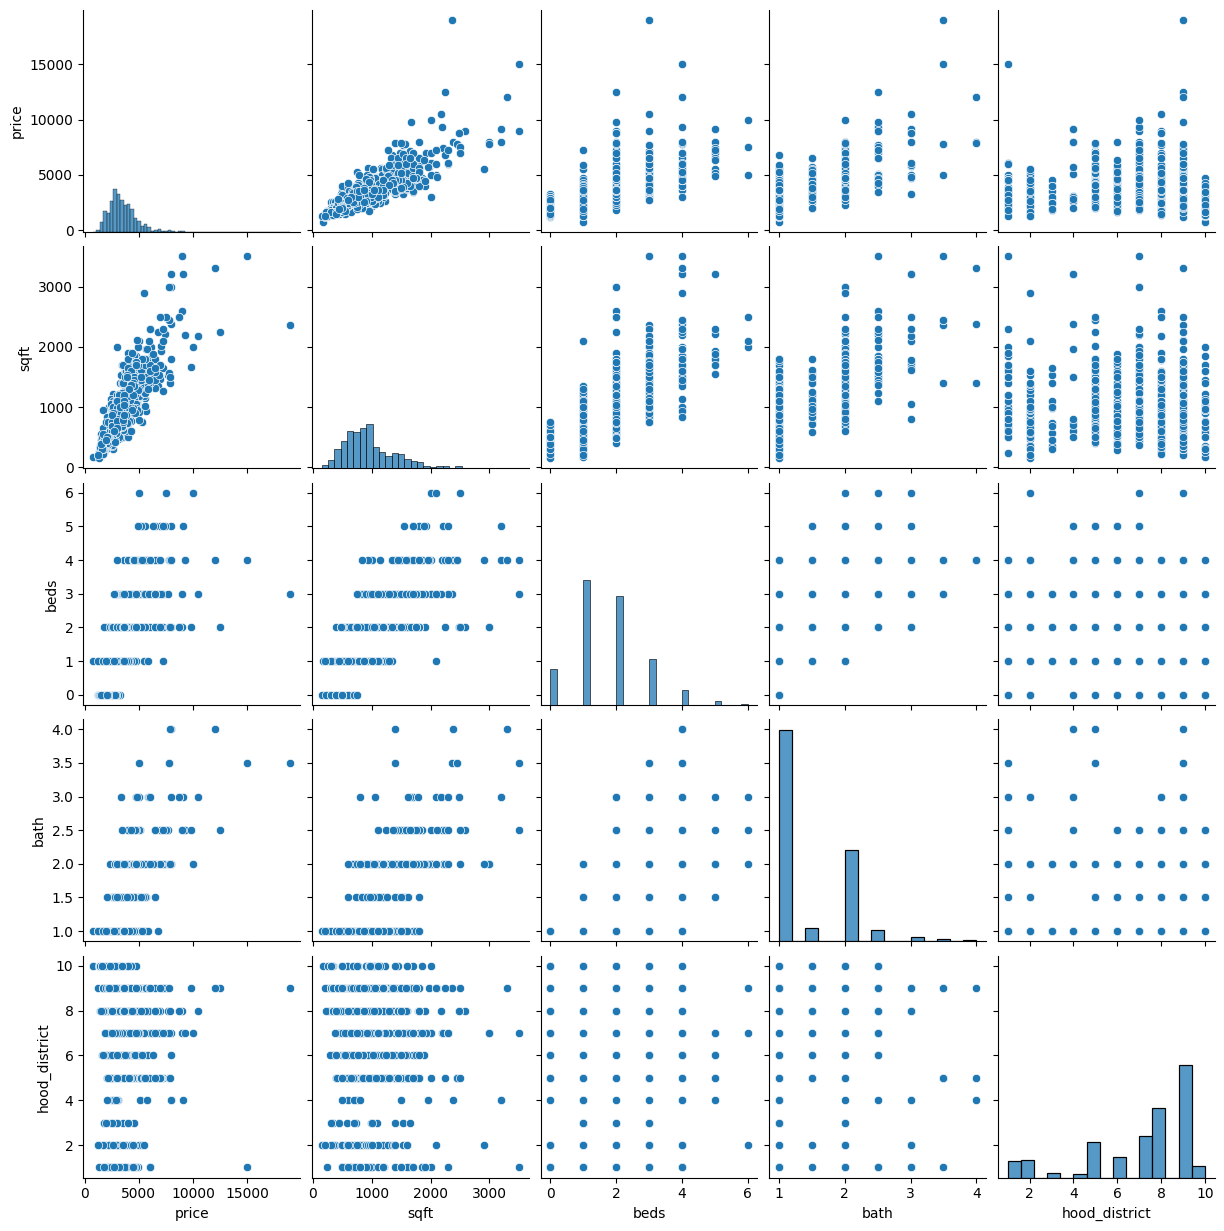

In [8]:
sns.pairplot(data=rentals)

<Axes: >

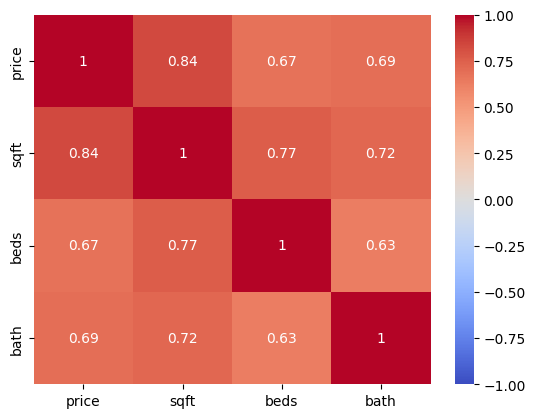

In [9]:
sns.heatmap(data=rentals.corr(numeric_only=True),vmin=-1,vmax=+1,annot=True,cmap="coolwarm")

In [10]:
def show_counts(df):
    for cols in df.select_dtypes(['object']).columns:
        print(df[cols].value_counts())

In [11]:
show_counts(rentals)

laundry
(a) in-unit       488
(b) on-site       370
(c) no laundry    131
Name: count, dtype: int64
pets
(d) no pets    510
(a) both       367
(c) cats        91
(b) dogs        21
Name: count, dtype: int64
housing_type
(c) multi     937
(a) single     40
(b) double     12
Name: count, dtype: int64
parking
(d) no parking    478
(b) protected     439
(c) off-street     38
(a) valet          34
Name: count, dtype: int64
hood_district
9.0     332
8.0     207
7.0     123
5.0     106
6.0      62
2.0      51
1.0      50
10.0     33
3.0      14
4.0      11
Name: count, dtype: int64


In [12]:
def plot_bar(df,target):
    for cols in df.select_dtypes(['object']).columns:
        sns.barplot(data=df,x=cols,y=target,errorbar=None)
        plt.show()

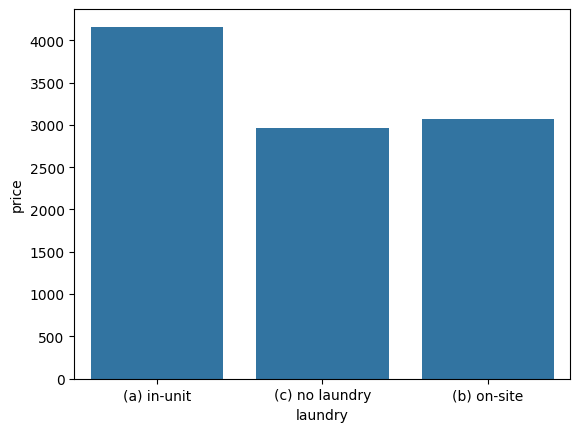

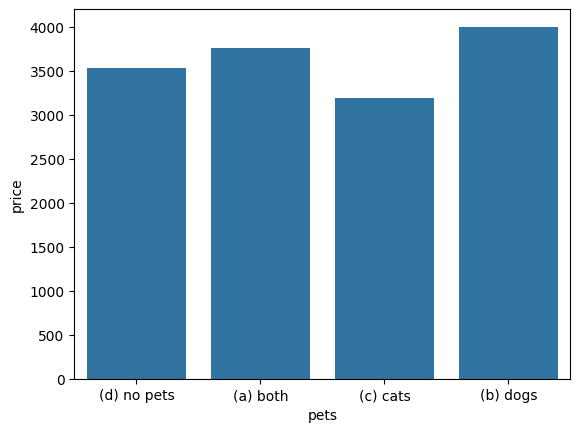

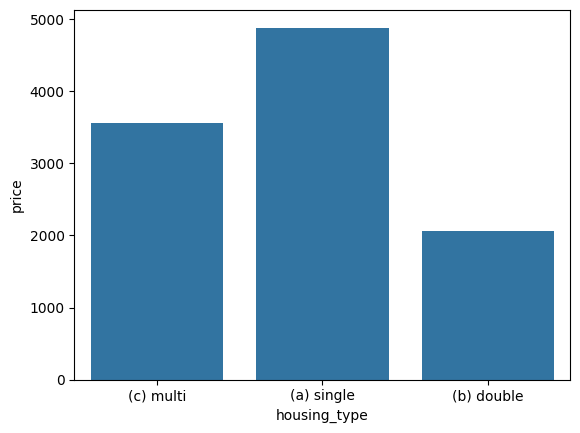

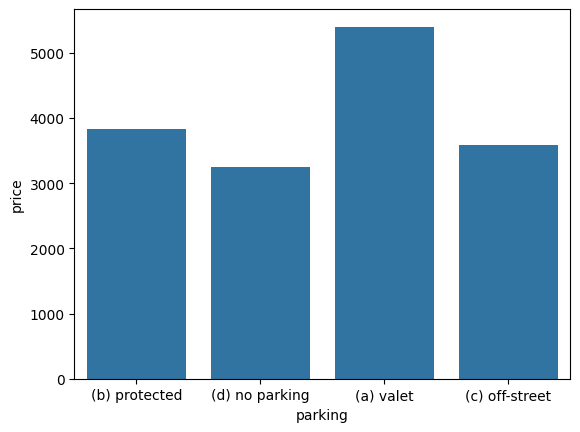

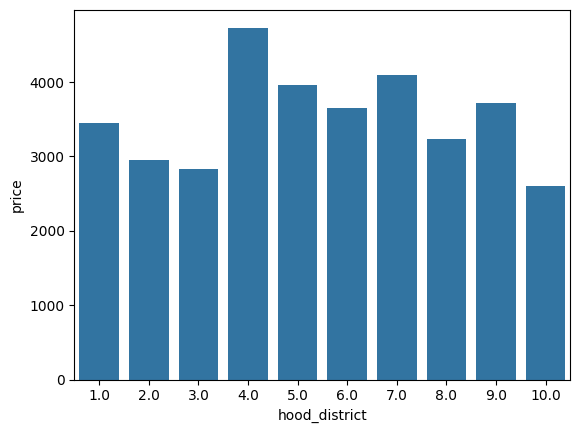

In [13]:
plot_bar(rentals,"price")

## Feature Engineering

In [14]:
laundry_map = {
    '(a) in-unit' : "in-unit",    
    '(b) on-site' : "not in-unit",   
    '(c) no laundry' : "not in-unit",
}

pet_map = {
    "(a) both": "allows_dogs",
    "(b) dogs": "allows_dogs",
    "(c) cats": "no_dogs",
    "(d) no pets": "no_dogs"
}

house_map = {
    '(c) multi' : 'multi',  
    '(a) single' : 'single',
    '(b) double'   : 'multi'
}

district_map = {
    1.0: "west",
    2.0: "southwest",
    3.0: "southwest",
    4.0: "central",
    5.0: "central",
    6.0: "central",
    7.0: "marina",
    8.0: "north beach",
    9.0: "FiDi/SOMA",
    10.0: "southwest"   
}

In [15]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          989 non-null    int64  
 1   sqft           989 non-null    float64
 2   beds           989 non-null    float64
 3   bath           989 non-null    float64
 4   laundry        989 non-null    object 
 5   pets           989 non-null    object 
 6   housing_type   989 non-null    object 
 7   parking        989 non-null    object 
 8   hood_district  989 non-null    object 
dtypes: float64(3), int64(1), object(5)
memory usage: 69.7+ KB


In [26]:
eng_rentals = rentals.assign(
                        laundry = rentals['laundry'].map(laundry_map),
                        pets = rentals['pets'].map(pet_map),
                        housing_type = rentals['housing_type'].map(house_map),
                        hood_district = rentals['hood_district'].map(district_map),
                        #sqft_2 = rentals['sqft'] ** 2, 
                        #sqft_3 = rentals['sqft'] ** 3,
                        #beds_2 = rentals_df['beds'] ** 2,
                        #beds_3 = rentals_df['beds'] ** 3,
                        #bath_2 = rentals_df['bath'] ** 2,
                        #bath_3 = rentals_df['bath'] ** 3,
                        #beds_bath_ratio = rentals_df["beds"] / rentals_df["bath"],
                    )

In [27]:
eng_rentals = pd.get_dummies(eng_rentals,drop_first=True)

'''eng_rentals = rentals.assign(
                        beds_housing = eng_rentals['beds'] * eng_rentals['housing_type_single'],
                        bath_housing = eng_rentals['bath'] * eng_rentals['housing_type_single'],
                    )'''

eng_rentals.head()

,price,sqft,beds,bath,laundry_not in-unit,pets_no_dogs,housing_type_single,parking_(b) protected,parking_(c) off-street,parking_(d) no parking,hood_district_central,hood_district_marina,hood_district_north beach,hood_district_southwest,hood_district_west
0,6800,1600.0,2.0,2.0,False,True,False,True,False,False,False,True,False,False,False
1,3500,550.0,1.0,1.0,False,False,False,True,False,False,False,True,False,False,False
2,5100,1300.0,2.0,1.0,False,False,False,False,False,True,False,True,False,False,False
3,9000,3500.0,3.0,2.5,False,True,False,True,False,False,False,True,False,False,False
4,3100,561.0,1.0,1.0,True,False,False,False,False,True,False,True,False,False,False


## Data Splitting

In [28]:
target = 'price'
drop_features = [
    'price',
    'pets_no_dogs',
    'hood_district_west',
    'hood_district_north beach',
    'hood_district_north beach',
    'housing_type_single',
]

X = sm.add_constant(eng_rentals.drop(drop_features,axis = 1))
y = np.log(eng_rentals[target])

X,X_test,y,y_test = train_test_split(X,y,test_size=0.2,random_state=2023)


In [29]:
bool_x_cols = X.select_dtypes(include='bool').columns
bool_x_test_cols = X_test.select_dtypes(include='bool').columns

In [30]:
X[bool_x_cols] = X[bool_x_cols].astype(int)
X_test[bool_x_test_cols] = X_test[bool_x_test_cols].astype(int)

In [34]:
X

,const,sqft,beds,bath,laundry_not in-unit,parking_(b) protected,parking_(c) off-street,parking_(d) no parking,hood_district_central,hood_district_marina,hood_district_southwest
838,1.0,800.0,1.0,1.0,1,0,1,0,0,0,0
226,1.0,1000.0,4.0,1.5,0,1,0,0,0,0,0
391,1.0,700.0,1.0,1.0,1,0,0,1,1,0,0
293,1.0,675.0,1.0,1.0,1,0,1,0,0,0,0
648,1.0,650.0,1.0,1.0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
929,1.0,1800.0,2.0,2.0,0,1,0,0,0,0,0
695,1.0,1000.0,2.0,1.0,0,1,0,0,1,0,0
454,1.0,1050.0,2.0,1.0,0,1,0,0,0,0,0
537,1.0,300.0,1.0,1.0,1,0,0,1,0,0,0


## Model Fitting & Validation Scoring

In [31]:
kf = KFold(n_splits=5,shuffle=True,random_state=2023)

train_R2 = []
valid_R2 = []

train_mae = []
valid_mae = []

for train_ind,valid_index in kf.split(X,y):
    X_train,y_train = X.iloc[train_ind],y.iloc[train_ind]
    X_valid,y_valid = X.iloc[valid_index],y.iloc[valid_index]

    model = sm.OLS(y_train,X_train).fit()

    train_R2.append(r2_score(y_train,model.predict(X_train)))
    valid_R2.append(r2_score(y_valid,model.predict(X_valid)))

    train_mae.append(mean_absolute_error(np.exp(y_train),np.exp(model.predict(X_train))))
    valid_mae.append(mean_absolute_error(np.exp(y_valid),np.exp(model.predict(X_valid))))

print(f"Training R2 : {round(np.mean(train_R2),3)} +- {round(np.std(train_R2),3)}")
print(f"Validation R2 : {round(np.mean(valid_R2),3)} +- {round(np.std(valid_R2),3)}")

print()

print(f"Training MAE : {round(np.mean(train_mae),3)} +- {round(np.std(train_mae),3)}")
print(f"Validation R2 : {round(np.mean(valid_mae),3)} +- {round(np.std(valid_mae),3)}")


Training R2 : 0.807 +- 0.004
Validation R2 : 0.796 +- 0.013

Training MAE : 496.49 +- 9.915
Validation R2 : 508.063 +- 53.328


In [32]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     253.9
Date:                Tue, 17 Jun 2025   Prob (F-statistic):          4.51e-212
Time:                        11:20:01   Log-Likelihood:                 213.64
No. Observations:                 633   AIC:                            -405.3
Df Residuals:                     622   BIC:                            -356.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       7.7965      0.044    177.444      0.000       7.710       7.883
sqft                        0.0004   2.61e-05     14.742      0.000       0.000       0.000
beds                        0.0982      0.010      9.588      0.000       0.078       0.118
bath                        0.0437      0.018      2.406      0.016       0.008       0.079
laundry_not in-unit        -0.1005      0.016     -6.427      0.000      -0.131      -0.070
parking_(b) protected      -0.2084      0.039     -5.380      0.000      -0.285      -0.132
parking_(c) off-street     -0.1774      0.055     -3.247      0.001      -0.285      -0.070
parking_(d) no parking     -0.2858      0.040     -7.192      0.000      -0.364      -0.208
hood_district_central       0.0383      0.019      1.996      0.046       0.001       0.076
hood_district_marina        0.0971      0.023      4.308      0.000       0.053       0.141
hood_district_southwest    -0.1606      0.024     -6.592      0.000      -0.208      -0.113
==============================================================================
Omnibus:                       19.861   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.508
Skew:                           0.119   Prob(JB):                     9.70e-10
Kurtosis:                       4.232   Cond. No.                     1.29e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Assumptions Checking
1. Linearity - no obvious curvature
2. Independence - DW Test Statistic 
3. Normality - Slighly off before log transform, much better afterwards... may not be worth interpretability
4. No Perfect MultiCollinearity - VIFs 
5. Equal Variance - log transform heteroskedasticity if found

In [33]:
def resid_and_prob(df):
    predictions = df.predict()
    residuals = df.resid
    fig,ax = plt.subplots(1,2,sharey="all",figsize = (10,6))
    sns.scatterplot(x = predictions,y = residuals,ax = ax[0])
    ax[0].set_title("Residual Plot")
    ax[0].set_xlabel("Predections")
    ax[0].set_ylabel("Residuals")
    stats.probplot(x = residuals,dist='norm',plot=ax[1])

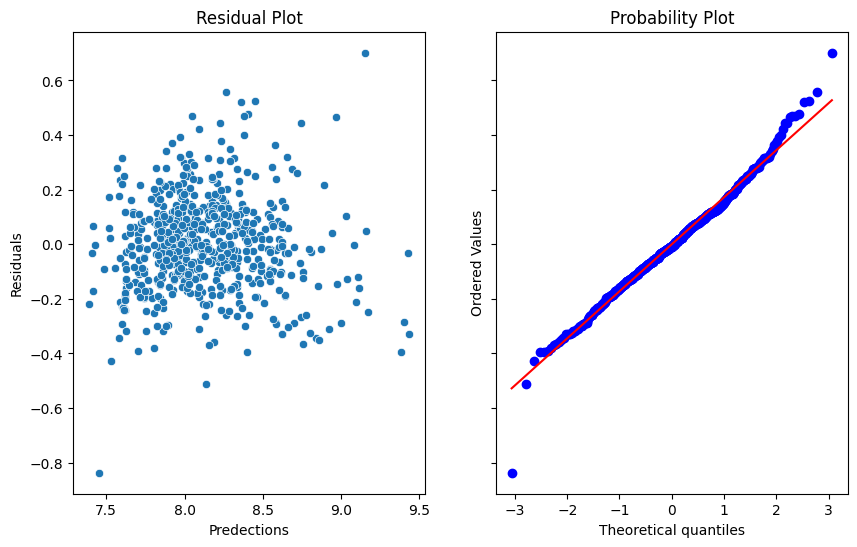

In [113]:
resid_and_prob(model)

In [114]:
pd.Series(
    [variance_inflation_factor(X.values,i) for i in range(X.shape[1])],
    index=X.columns
)

const                      39.418400
sqft                        3.444385
beds                        2.740735
bath                        2.286747
laundry_not in-unit         1.270671
parking_(b) protected       7.572965
parking_(c) off-street      2.197888
parking_(d) no parking      8.100551
hood_district_central       1.127554
hood_district_marina        1.153284
hood_district_southwest     1.109359
dtype: float64

In [115]:
model.get_influence().summary_frame()['cooks_d'].sort_values(ascending = False).head()

253    0.104074
56     0.047524
602    0.042408
3      0.033230
598    0.033041
Name: cooks_d, dtype: float64

## Final Model Fit & Test Scoring

In [116]:
final_model = sm.OLS(y,X).fit()
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     324.3
Date:                Sat, 14 Jun 2025   Prob (F-statistic):          5.63e-270
Time:                        12:41:14   Log-Likelihood:                 280.43
No. Observations:                 791   AIC:                            -538.9
Df Residuals:                     780   BIC:                            -487.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       7.7654      0.038    203.503      0.000       7.691       7.840
sqft                        0.0004   2.37e-05     16.559      0.000       0.000       0.000
beds                        0.0985      0.009     10.695      0.000       0.080       0.117
bath                        0.0467      0.016      2.880      0.004       0.015       0.079
laundry_not in-unit        -0.1012      0.014     -7.385      0.000      -0.128      -0.074
parking_(b) protected      -0.1878      0.034     -5.568      0.000      -0.254      -0.122
parking_(c) off-street     -0.1961      0.046     -4.287      0.000      -0.286      -0.106
parking_(d) no parking     -0.2658      0.035     -7.681      0.000      -0.334      -0.198
hood_district_central       0.0438      0.017      2.569      0.010       0.010       0.077
hood_district_marina        0.1008      0.020      5.130      0.000       0.062       0.139
hood_district_southwest    -0.1819      0.021     -8.566      0.000      -0.224      -0.140
==============================================================================
Omnibus:                       18.590   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.559
Skew:                           0.127   Prob(JB):                     5.16e-08
Kurtosis:                       3.977   Cond. No.                     1.24e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [117]:
print(f"Final Model R2 score : {np.round(r2_score(y_test,model.predict(X_test)),3)}")
print(f"Final Model MAE : {np.round(mean_absolute_error(np.exp(y_test),np.exp(model.predict(X_test))),3)}")

Final Model R2 score : 0.784
Final Model MAE : 436.488


### Save the model as pkl file

- `joblib.dump(...)` saves the `final_model` to a file.
- `'model.pkl'` is the name of the file where the model is stored in **Pickle format**.
- This file can later be **loaded and used for making predictions** without retraining the model.

In [118]:
import joblib

joblib.dump(final_model,'model.pkl')

['model.pkl']

## Conclusion
The linear regression model built during this analysis provides a reasonable fit to the data, with an R² score of 0.784 on the test set. While the model captures most of the variability, there may still be opportunities to improve its accuracy. Feature engineering, hyperparameter tuning, or experimenting with other models could further enhance performance. Overall, the project demonstrates the steps involved in preprocessing data, training a linear model, and evaluating its performance.


## Future Work
- Experiment with other algorithms like Decision Trees or Random Forests to compare performance.
- Perform more feature engineering to improve the model's ability to generalize.
- Tune hyperparameters to optimize model performance further.